In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt


data = pd.read_csv('../data/transformed_data/all_time_series.csv', index_col=0)

In [34]:
# define dickey fuller test function
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    return dfoutput['p-value']    


In [35]:
for column in data.columns:
    data[column + '_diff'] = data[column].diff().dropna()
    print(f'Testing stationarity for {column}')
    result = test_stationarity(data[column + '_diff'].dropna())
    print(f'p-value: {result} for {column}')



Testing stationarity for art
Results of Dickey-Fuller Test:
p-value: 0.00026032936003619666 for art
Testing stationarity for hype
Results of Dickey-Fuller Test:
p-value: 0.0001115885419042548 for hype
Testing stationarity for gf_index
Results of Dickey-Fuller Test:
p-value: 2.022124487083598e-30 for gf_index
Testing stationarity for spy
Results of Dickey-Fuller Test:
p-value: 2.1233678508941067e-30 for spy


In [36]:
import statsmodels.api as sm

# Assuming 'data' is your DataFrame
# Select appropriate columns
selected_columns = [ 'art_diff', 'hype_diff',
       'gf_index_diff', 'spy_diff']  # Fill with names of columns to use
data_svar = data[selected_columns]

# add svar dummy column
# drop all NaN valuesdd
data_svar = data_svar.dropna()

# determine optimal lag
model = sm.tsa.VAR(data_svar)
lag_results = model.select_order(15).summary()

# plot lag results


/Users/simon/Documents/Uni/Statistic/Semester 6/svar-causal/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [37]:
lag_results

,AIC,BIC,FPE,HQIC
0,6.623,6.667,751.9,6.640
1,5.573,5.796*,263.2,5.662
2,5.505,5.906,245.9,5.665
3,5.547,6.126,256.4,5.777
4,5.508,6.265,246.6,5.809
5,5.361,6.297,213.1,5.734
6,5.171,6.285,176.3,5.615*
7,5.201,6.494,181.8,5.716
8,5.188,6.659,179.6,5.774
9,5.188,6.837,179.7,5.844


In [39]:
data

,art,hype,gf_index,spy,art_diff,hype_diff,gf_index_diff,spy_diff
Date,,,,,,,,
2023-01-18,NaN,NaN,58.4286,391.49,NaN,NaN,NaN,NaN
2023-01-19,NaN,NaN,55.4286,388.64,NaN,NaN,-3.0000,-2.85
2023-01-20,NaN,NaN,58.5429,395.88,NaN,NaN,3.1143,7.24
2023-01-21,NaN,NaN,59.9429,395.88,NaN,NaN,1.4000,0.00
2023-01-22,286.660846,112.496463,59.9429,395.88,NaN,NaN,0.0000,0.00
...,...,...,...,...,...,...,...,...
2024-01-13,184.838767,37.133485,71.1143,476.68,1.247702,-0.958081,0.0000,0.00
2024-01-14,182.831526,37.196537,71.1143,476.68,-2.007241,0.063051,0.0000,0.00
2024-01-15,183.505241,37.496788,71.1143,476.68,0.673714,0.300251,0.0000,0.00


In [40]:
import numpy as np
import statsmodels.api as sm

# Assuming 'data_svar' is your DataFrame with the time series
data.columns = ['Art Market Index', 'Hype Collection index', 'Greed and Fear', 'SPY','Art Market Index_diff', 'Hype Collection index_diff', 'Greed and Fear_diff', 'SPY_diff']
data_svar = data[['Art Market Index_diff', 'Hype Collection index_diff', 'Greed and Fear_diff', 'SPY_diff']]
# rename columns
data_svar['Artmarket Shock'] = 0
dates = ['2023-06-15', '2023-02-06', '2023-07-24', '2023-06-06']
for date in dates:
    if date == '2023-06-15':
        data_svar.loc[data_svar.index == date, 'Artmarket Shock'] = 1
    else:
        data_svar.loc[data_svar.index == date, 'Artmarket Shock'] = 0.1

data_svar.dropna(inplace=True)
# Correctly define the A matrix based on the relationships
A = np.array([
    [1, 'E', 'E', 'E', 0],  # art_diff
    ['E', 1, 0, 0, 0],  # hype_diff
    ['E', 'E', 1, 'E', 0],        # gf_index_diff
    ['E', 0, 0, 1, 0],    # spy_diff
    ['E', 0, 0, 0, 1]         # shock_art_diff
]
)
# Create the SVAR model instance
model = sm.tsa.SVAR(data_svar, svar_type='A', A=A)

# Fit the model
results = model.fit(maxlags=11)

results.k_exog_user = 0 # https://github.com/statsmodels/statsmodels/issues/8025
# Print the summary
results.summary()

/var/folders/rp/1xxr_95d09j_t6cjf0dp36bh0000gn/T/ipykernel_53275/3794518434.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_svar['Artmarket Shock'] = 0
/var/folders/rp/1xxr_95d09j_t6cjf0dp36bh0000gn/T/ipykernel_53275/3794518434.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_svar.dropna(inplace=True)
/Users/simon/Documents/Uni/Statistic/Semester 6/svar-causal/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(date

  Summary of Regression Results   
Model:                        SVAR
Method:                        OLS
Date:           Sun, 21, Jan, 2024
Time:                     00:45:27
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    2.72100
Nobs:                     349.000    HQIC:                  0.859314
Log likelihood:          -2131.15    FPE:                   0.699136
AIC:                    -0.371897    Det(Omega_mle):        0.332211
--------------------------------------------------------------------
Results for equation Art Market Index_diff
                                    coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------------
const                                  0.120533         0.212689            0.567           0.571
L1.Art Market Index_diff               0.307254         0.056552          

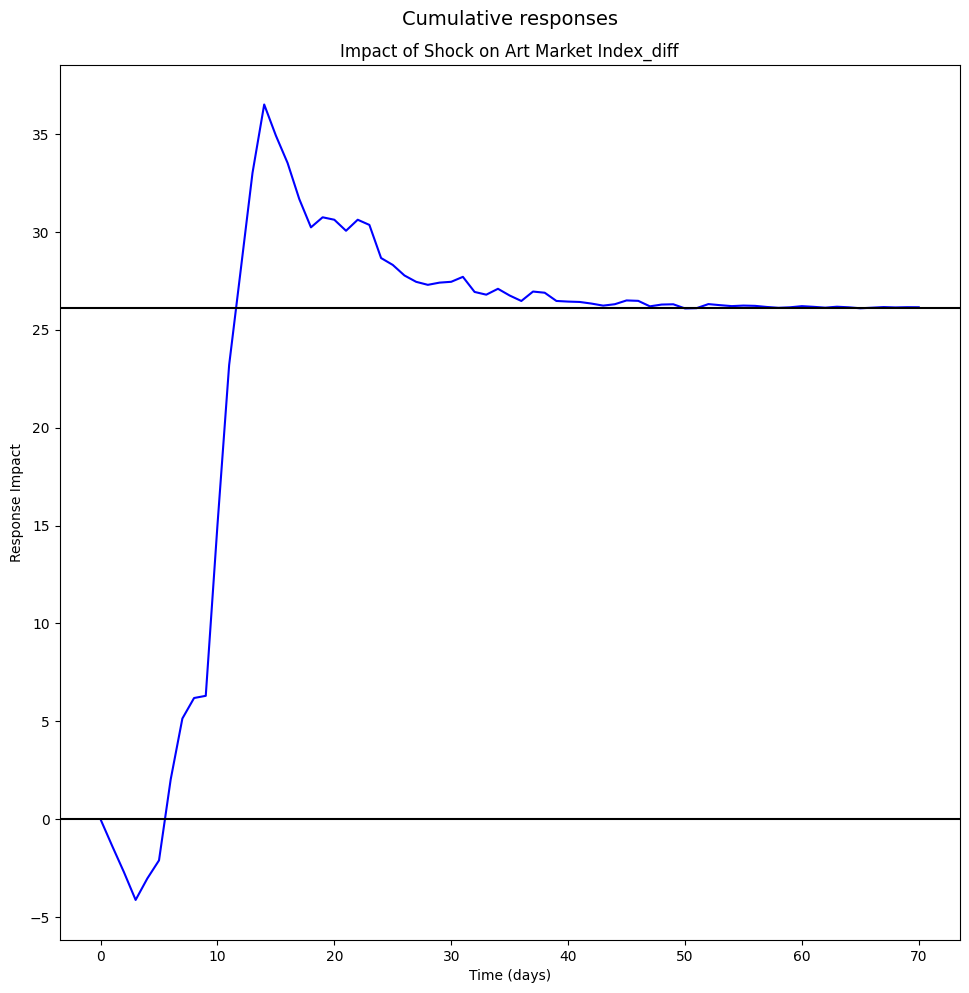

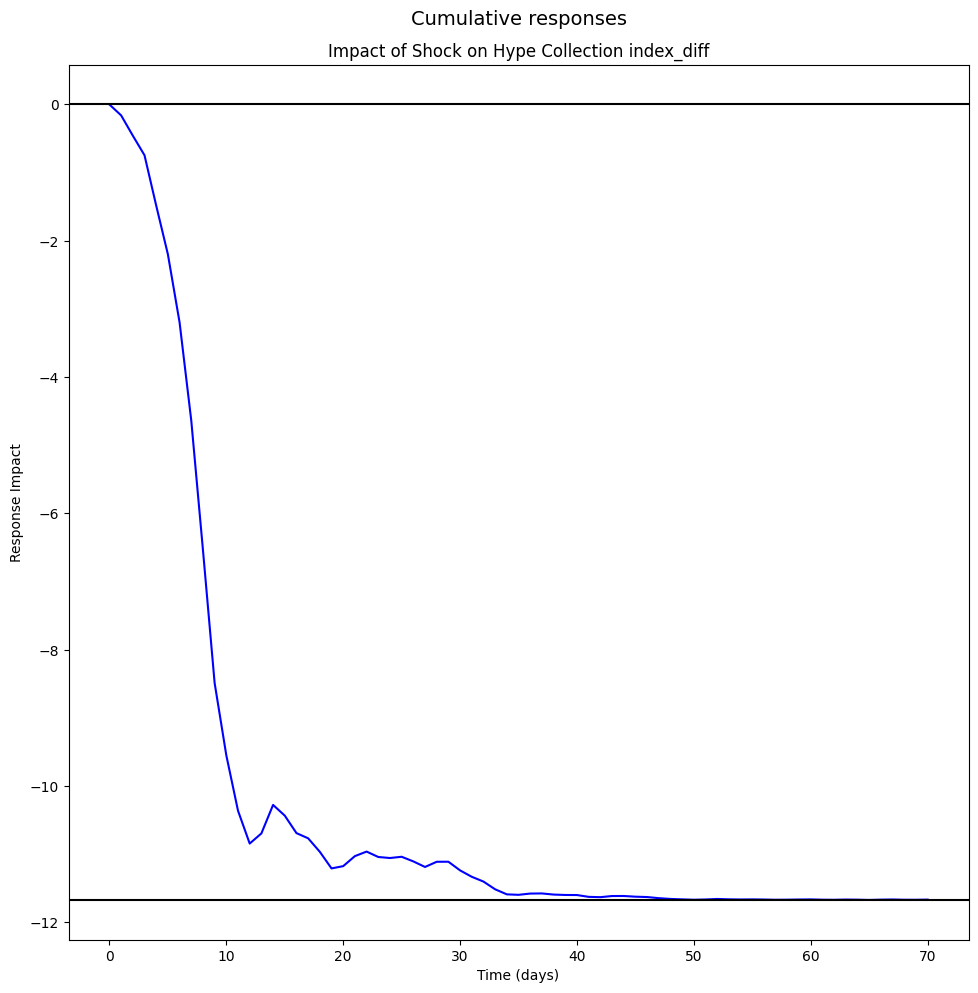

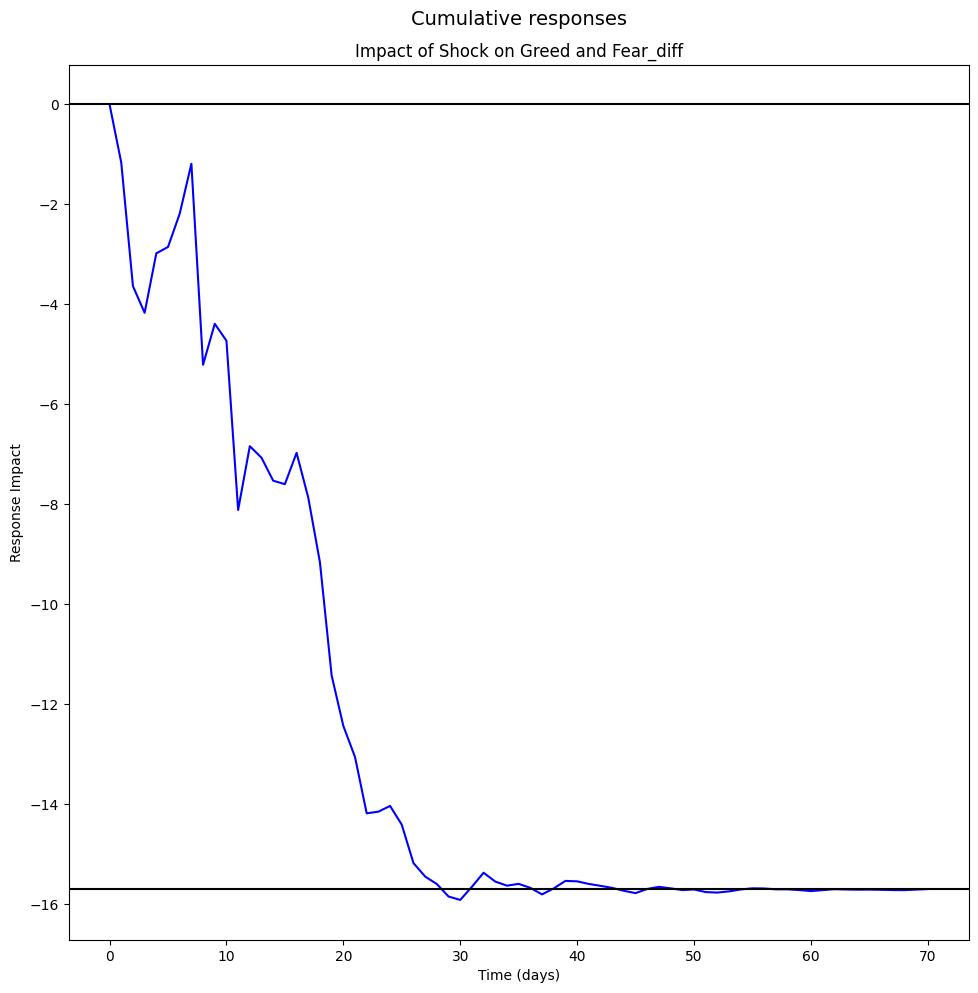

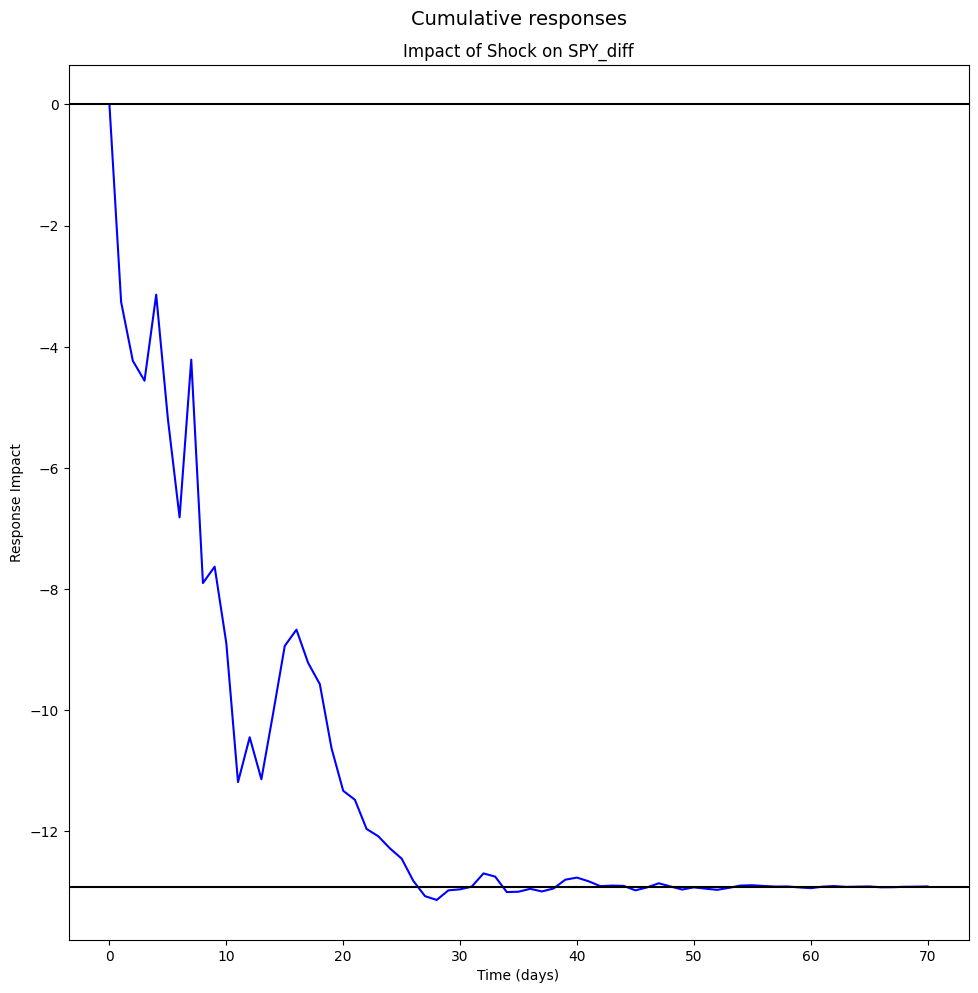

In [69]:
import matplotlib.pyplot as plt

# Number of periods to forecast
periods = 70

# Generate impulse response functions
irf = results.irf(periods)

# Plot the impulse responses of all variables to the shock in the dummy variable
# Assuming the dummy variable is the last one in your model
for i in range(len(data_svar.columns) - 1):  # Exclude the dummy itself
    irf.plot_cum_effects(impulse=len(data_svar.columns) - 1, response=i, plot_stderr=False)
    plt.title(f'Impact of Shock on {data_svar.columns[i]}')

    plt.xlabel('Time (days)')
    plt.ylabel('Response Impact')
    plt.show()
